# Coin Detection Challenge - Image Analysis and Pattern Recognition - 2024
Lucille Niederhauser - Meriam Bouguecha - Raphaëlle Hartwig - Group 55

Kaggle team: Group 55

The goal of this project was to build an automatic system that can identify swiss franc and euro coins on an image with various backgrounds. To do so, we tackled the following tasks:
1. Background detection
2. Segmentation of coins for each background (neutral, noisy, hand)
3. Classifying single coins into CHF, EUR or OOD
4. Classifying CHF into their exact values
5. Classifying EUR into their exact values

In [104]:
# Import main packages & files
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
import numpy as np
import seaborn as sns
import cv2
import os
import random
from torch.utils.data import TensorDataset
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from torchsummary import summary

from utils import *
from classify_background import *
from segmentation import *
from classification import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The cell below defines the directory used in this project. The provided dataset should be located in the original_train_path and original_test_path for train and test images respectively. Additionally, the following directories need to be created and will be used to stored preprocessed data:
- './preprocessed_data/downsampled/train/'
- './preprocessed_data/downsampled/test/'
- './data/cropped/train/'

The above structure is already created in our submission folder

In [91]:
# define paths used
original_train_path = './data/train/'
original_test_path = './data/test/'
train_path = './preprocessed_data/downsampled/train/'
test_path = './preprocessed_data/downsampled/test/'
cropped_path = './data/cropped/train/'

In [114]:
# set the seeds for reproducibility
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# define device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Background Detection
When starting to explore segmentation techniques, we quickly realised that it would be complicated to find one segmentation technique that is able to correctly indentify coins on all three backgrounds. We therefore decided to first create a function that given any image could find if the background was neutral, noisy or hand.

Each background has specific features making it easily recognizable. We decided to look at the HSV and RGB values of the train images to find the best thresholds classifying the backgrounds. To do so, we used the following procedure and functions : 
- Compute mean, min and max values on the folder : compute_mean_hsv
- Plot these values to find a threshold : plot_mean_min_max_HSV and plot_mean_min_max_RGB

To compare these features in function of the background, we manually separated the train images (with and without outliers) in separate folders and analyzed them.

In [4]:
neutral_folder = './data/train/all/neutral'
noisy_folder = './data/train/all/noisy'
hand_folder = './data/train/all/hand'
all_folder = './data/train/all'

#### RGB thresholds

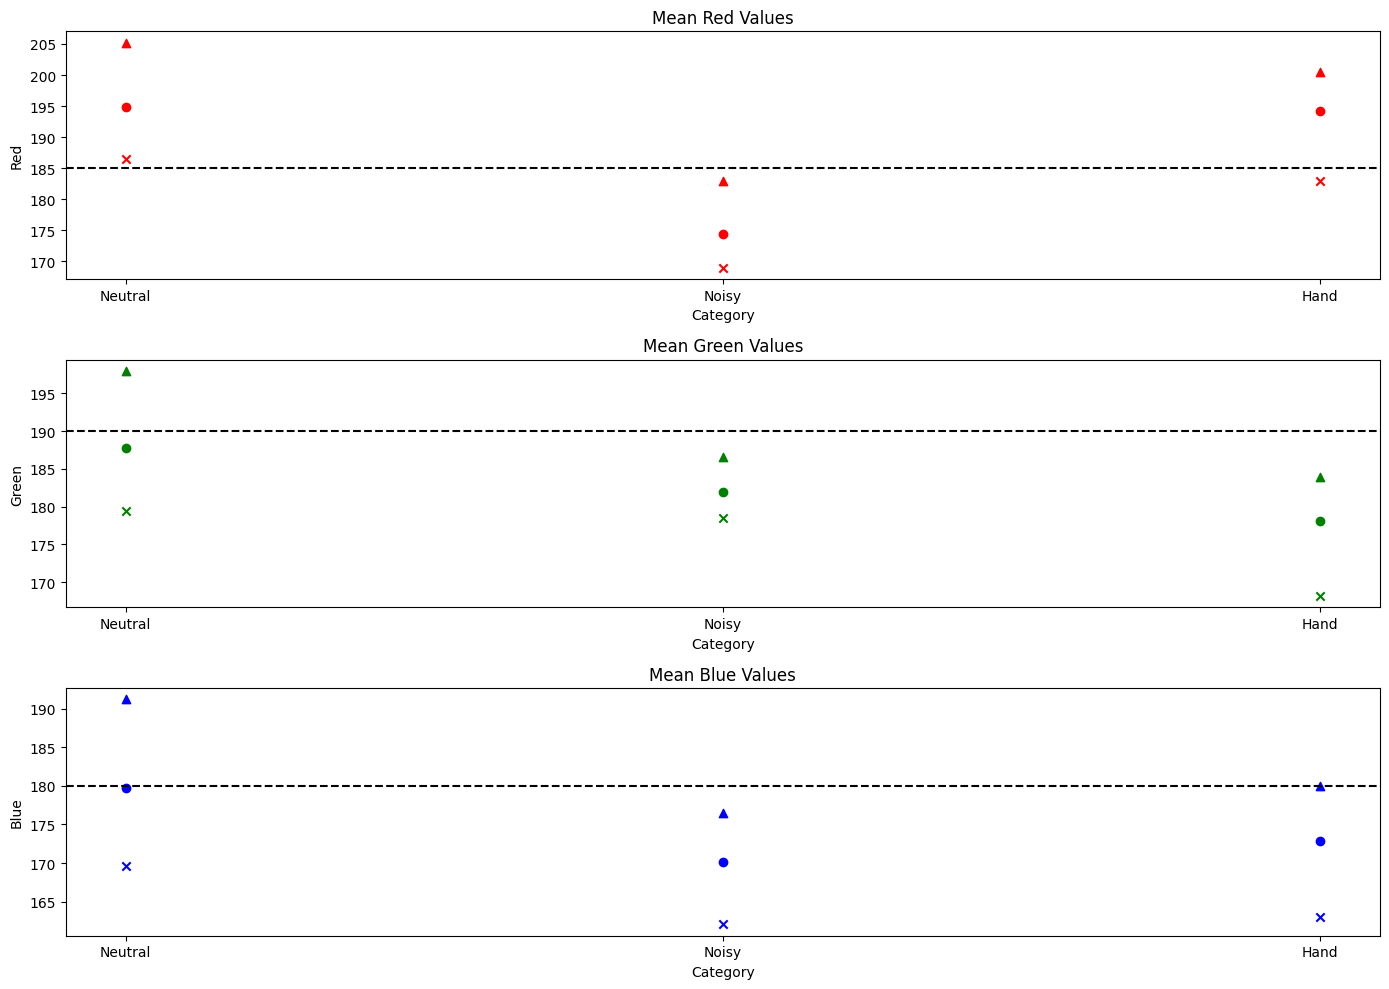

In [16]:
# FOLDER NEUTRAL
(mean_r_neutral, mean_g_neutral, mean_b_neutral,
 min_r_neutral, min_g_neutral, min_b_neutral,
 max_r_neutral, max_g_neutral, max_b_neutral) = compute_mean_rgb(neutral_folder)

# FOLDER NOISY
(mean_r_noisy, mean_g_noisy, mean_b_noisy,
 min_r_noisy, min_g_noisy, min_b_noisy,
 max_r_noisy, max_g_noisy, max_b_noisy) = compute_mean_rgb(noisy_folder)

# FOLDER HAND
(mean_r_hand, mean_g_hand, mean_b_hand,
 min_r_hand, min_g_hand, min_b_hand,
 max_r_hand, max_g_hand, max_b_hand) = compute_mean_rgb(hand_folder)

# Define mean_std_values
RGB_values = {
    'Neutral': {'Red': (mean_r_neutral, min_r_neutral, max_r_neutral), 
                'Green': (mean_g_neutral, min_g_neutral, max_g_neutral), 
                'Blue': (mean_b_neutral, min_b_neutral, max_b_neutral)},
    'Noisy': {'Red': (mean_r_noisy, min_r_noisy, max_r_noisy), 
              'Green': (mean_g_noisy, min_g_noisy, max_g_noisy), 
              'Blue': (mean_b_noisy, min_b_noisy, max_b_noisy)},
    'Hand': {'Red': (mean_r_hand, min_r_hand, max_r_hand), 
             'Green': (mean_g_hand, min_g_hand, max_g_hand), 
             'Blue': (mean_b_hand, min_b_hand, max_b_hand)}
}

plot_mean_min_max_RGB(RGB_values)

#### HSV thresholds

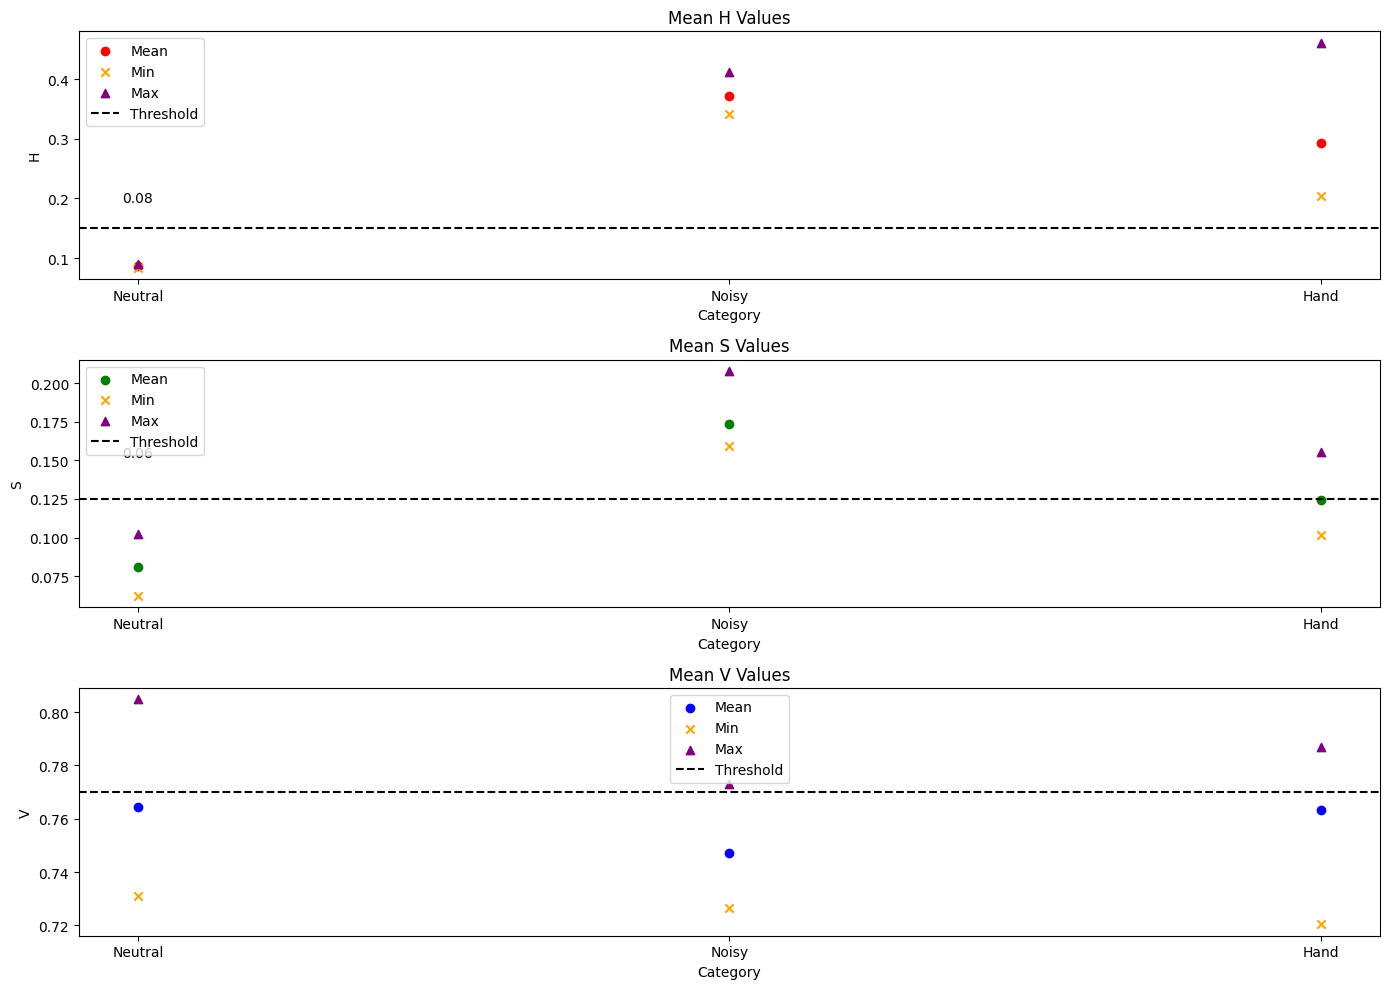

In [7]:
# FOLDER NEUTRAL
(mean_h_neutral, mean_s_neutral, mean_v_neutral,
 min_h_neutral, min_s_neutral, min_v_neutral,
 max_h_neutral, max_s_neutral, max_v_neutral) = compute_mean_hsv(neutral_folder)
# FOLDER NOISY
(mean_h_noisy, mean_s_noisy, mean_v_noisy,
 min_h_noisy, min_s_noisy, min_v_noisy,
 max_h_noisy, max_s_noisy, max_v_noisy) = compute_mean_hsv(noisy_folder)
# FOLDER HAND
(mean_h_hand, mean_s_hand, mean_v_hand,
 min_h_hand, min_s_hand, min_v_hand,
 max_h_hand, max_s_hand, max_v_hand) = compute_mean_hsv(hand_folder)

# Define mean_std_values for HSV
HSV_values = {
    'Neutral': {'H': (mean_h_neutral, min_h_neutral, max_h_neutral), 
                'S': (mean_s_neutral, min_s_neutral, max_s_neutral), 
                'V': (mean_v_neutral, min_v_neutral, max_v_neutral)},
    'Noisy': {'H': (mean_h_noisy, min_h_noisy, max_h_noisy), 
              'S': (mean_s_noisy, min_s_noisy, max_s_noisy), 
              'V': (mean_v_noisy, min_v_noisy, max_v_noisy)},
    'Hand': {'H': (mean_h_hand, min_h_hand, max_h_hand), 
             'S': (mean_s_hand, min_s_hand, max_s_hand), 
             'V': (mean_v_hand, min_v_hand, max_v_hand)}
}

plot_mean_min_max_HSV(HSV_values)

Looking at these plots, we observe that a **simple threshold on HSV an RGB values won't separate well** the backgrounds. To further analyze these channels, we decided to look at the histogram distributions.

### 1. 2. Histogram thresholds

RGB histograms

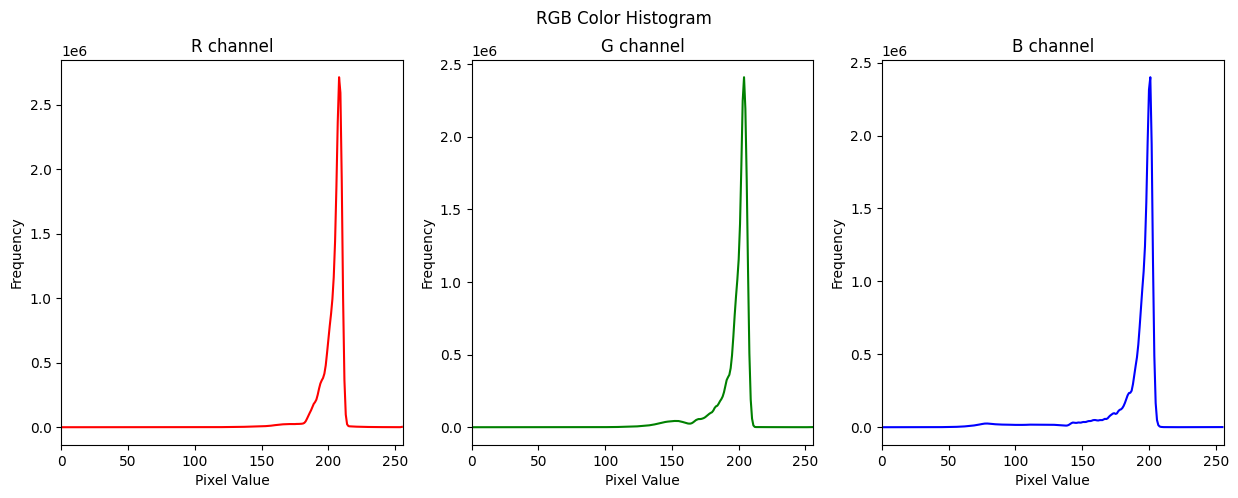

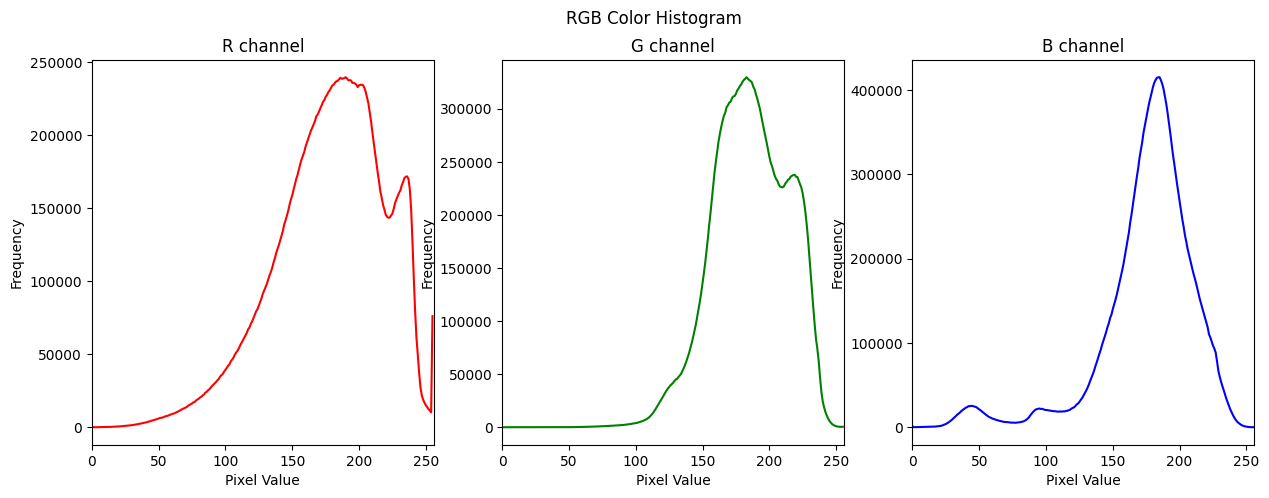

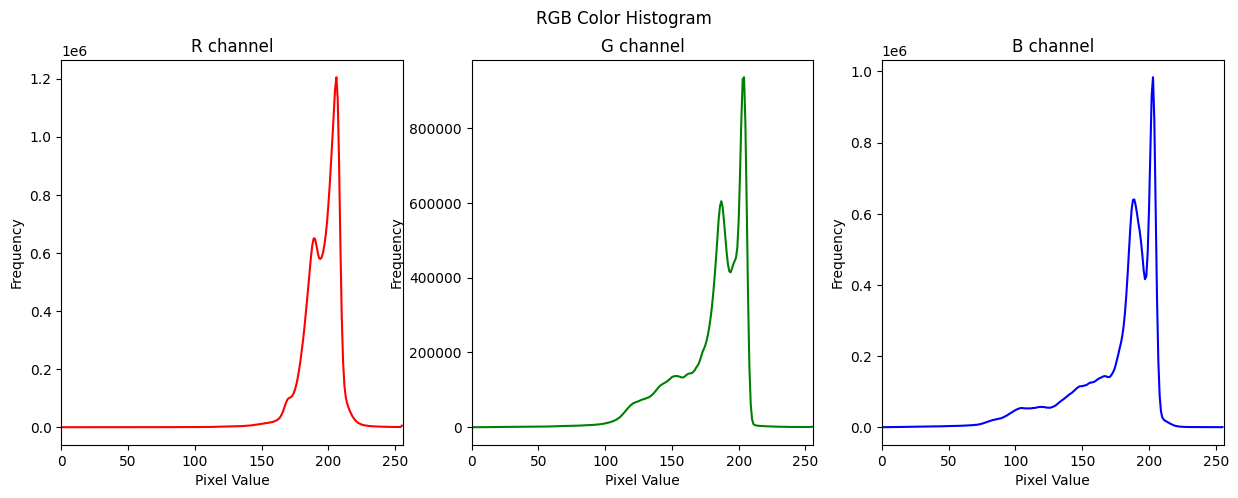

In [5]:
compute_and_plot_rgb_histogram(Image.open(os.path.join(neutral_folder, os.listdir(neutral_folder)[0])))
compute_and_plot_rgb_histogram(Image.open(os.path.join(noisy_folder, os.listdir(noisy_folder)[0])))
compute_and_plot_rgb_histogram(Image.open(os.path.join(hand_folder, os.listdir(hand_folder)[0])))

From the histogram plots, the distributions seem to vary quite much in function of the background, especially in the case of the noisy background. A first threshold distinguishing the **noisy** from the other backgrounds can be applied. Many different thresholds are possible, we decided to threshold on the **blue channel**.

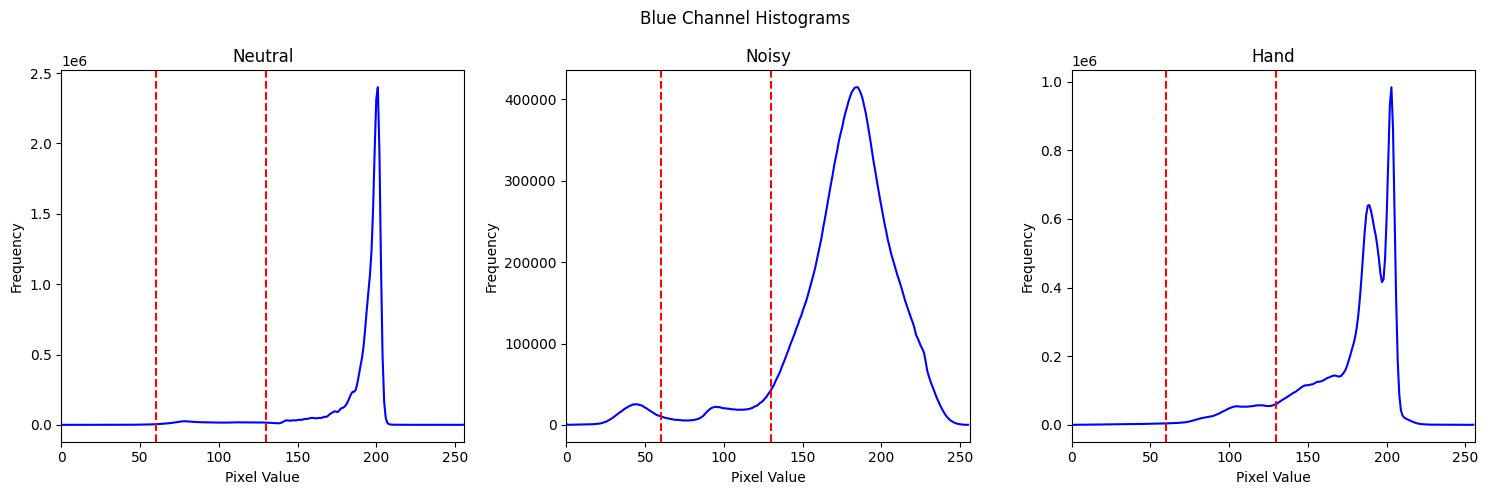

In [6]:
images = [
    io.imread(os.path.join(neutral_folder, os.listdir(neutral_folder)[0])),
    io.imread(os.path.join(noisy_folder, os.listdir(noisy_folder)[0])),
    io.imread(os.path.join(hand_folder, os.listdir(hand_folder)[0]))
]

titles = ['Neutral', 'Noisy', 'Hand']

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot V channel histograms for the selected images
for ax, image, title in zip(axes, images, titles):
    compute_and_plot_b_histogram(image, ax)
    ax.set_title(title)

plt.suptitle('Blue Channel Histograms')
plt.tight_layout()
plt.show()


Looking at the blue channels plots we can approximate that pixels between 60 and 130 shows a higher density in the case of the noisy background.

In [7]:
def noisy_threshold(noisy_folder):
    filenames = os.listdir(noisy_folder)
    for filename in filenames:
        img_path = os.path.join(noisy_folder, filename)
        img = io.imread(img_path)
        hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        threshold_noisy = (hsv_image[:, :, 0] > 60) & (hsv_image[:, :, 0] < 130)
        if np.sum(threshold_noisy) <= 1000000:
            return False
    return True

print(noisy_threshold(noisy_folder))
print(noisy_threshold(hand_folder))
print(noisy_threshold(neutral_folder))

True
False
False


This condition is confirmed to be fulfilled for all images in the noisy folder.

HSV histograms

To find a second threshold we use the HSV distributions.

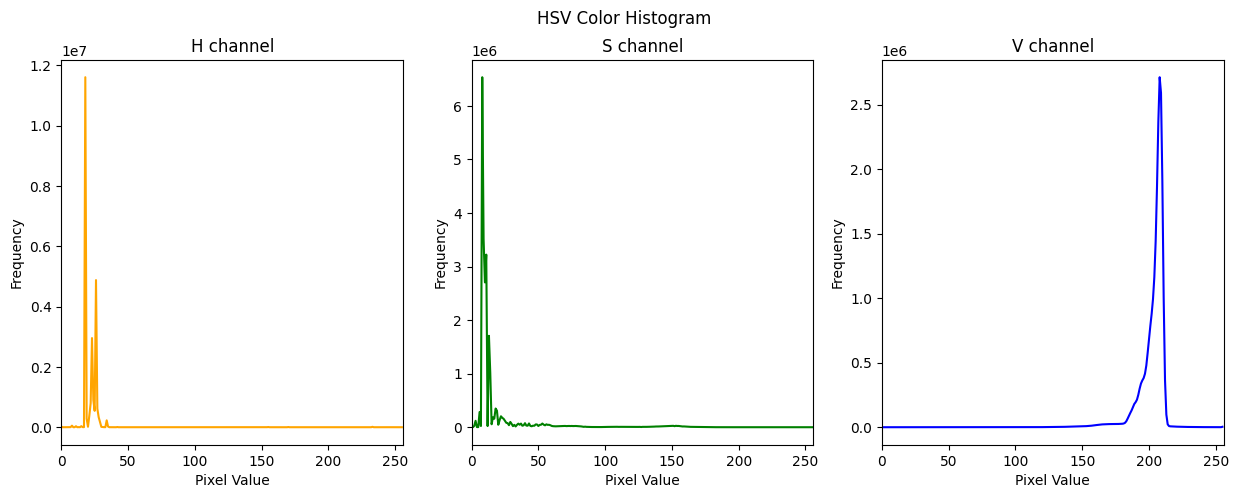

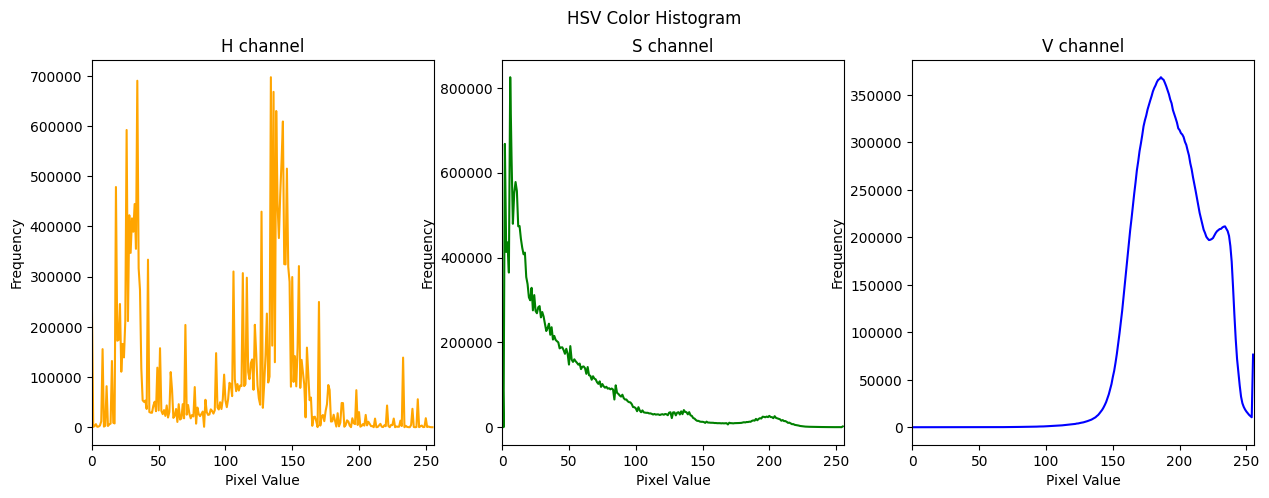

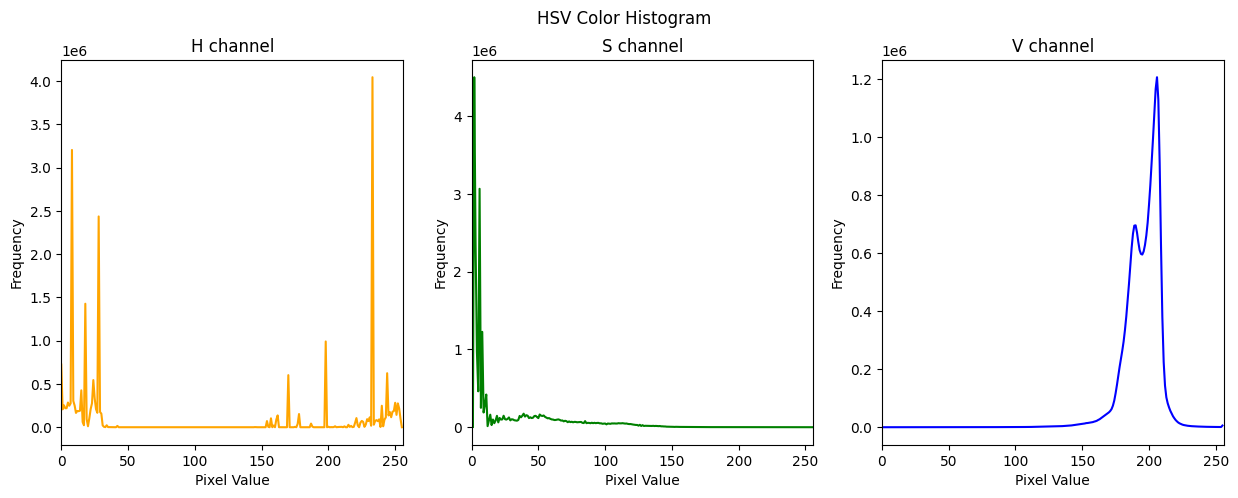

In [8]:
compute_and_plot_hsv_histogram(Image.open(os.path.join(neutral_folder, os.listdir(neutral_folder)[0])))
compute_and_plot_hsv_histogram(Image.open(os.path.join(noisy_folder, os.listdir(noisy_folder)[0])))
compute_and_plot_hsv_histogram(Image.open(os.path.join(hand_folder, os.listdir(hand_folder)[0])))

Again many different thresholds are possible, we decided to threshold on the **V channel**.

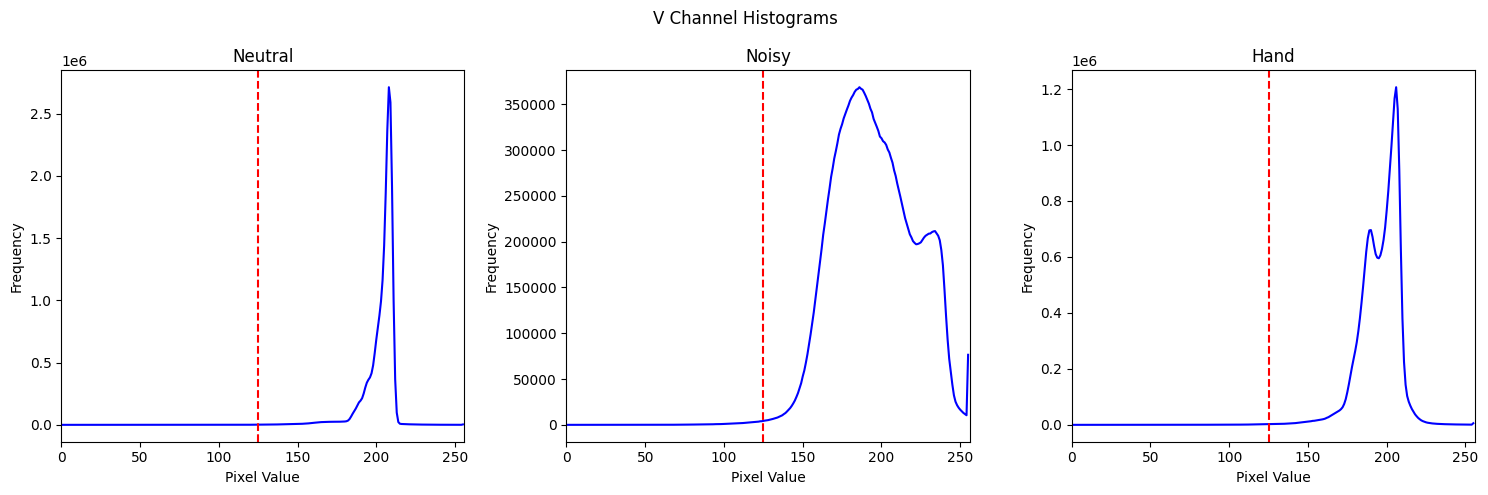

In [9]:
images = [
    Image.open(os.path.join(neutral_folder, os.listdir(neutral_folder)[0])),
    Image.open(os.path.join(noisy_folder, os.listdir(noisy_folder)[0])),
    Image.open(os.path.join(hand_folder, os.listdir(hand_folder)[0]))
]

titles = ['Neutral', 'Noisy', 'Hand']

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot V channel histograms for the selected images
for ax, image, title in zip(axes, images, titles):
    compute_and_plot_v_histogram(image, ax)
    ax.set_title(title)

plt.suptitle('V Channel Histograms')
plt.tight_layout()
plt.show()

Looking at the V channels plots, we can approximate that pixels above 125 shows a higher density in the case of the hand background.

In [10]:
def hand_threshold(hand_folder):
    filenames = os.listdir(hand_folder)
    for filename in filenames:
        img_path = os.path.join(hand_folder, filename)
        img = io.imread(img_path)
        hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        if np.sum((hsv_image[:, :, 0] > 125)) <= 500000:
            return False
    return True


print(hand_threshold(hand_folder))
print(hand_threshold(neutral_folder))

True
False


This condition is confirmed to be fulfilled for all images in the hand folder.

- The noisy histogram showed high density of values between 60 and 130 on the blue channel compared to the other backgrounds. We set the first threshold at a high value (1000000) of the sum of this window

- The hand background histogram showed dense values above 125 for the 'V' channel compared to the neutral background. We set the second threshold at a high value (500000) of the sum of this window. 

In [11]:
classify_images_in_folders(all_folder)

Classification rate: 100.00%


Computing the classification rate confirms that these thresholds work for all images of the train folder.

This approach resulted in the following function:

In [ ]:
def classify_background(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    threshold_noisy = ((image[:,:,0] > 60) & (image[:,:,0] < 130))
    threshold_hand = (hsv_image[:,:,0] > 125)

    if (np.sum(threshold_noisy)) > 1000000:
        background = "noisy"
        return background

    elif np.sum(threshold_hand) > 500000:
        background = "hand"
        return background

    else:
        background = "neutral"
        return background

# 2. Coins Segmentation
Once we were able to detect the background, we developped three segmentation function for each background type. However, before doing so we decided to downsample our images because the original images are big and thus any processing of them takes a lot of time.

In [93]:
downsample_images(original_train_path, train_path)
downsample_images(original_test_path, test_path)

The above functions take all the images in the original train and test set, downsamples them by 4 and saves them. This allowed us to gain computational time.

Segmenting coins from various backgrounds posed significant challenges due to the unique properties and influences of each background on luminance and key features of the coins. For each background, we analyzed characteristics in different color spaces, applied edge detection techniques, and performed extensive testing. Ultimately, we identified a combination of edge detection, thresholding, and other techniques that worked best for each scenario.

We utilized OpenCV for its powerful functions, particularly the Hough Circle Detector to detect coins on clean/thresholded images. 
Each function loads and preprocesses the image, applies the Hough Circle Transform to detect circles, optionally displays the result, and returns a list of detected circles' coordinates and radii.

### Neutral Background
For the neutral background, adaptive thresholding in OpenCV was highly effective. Adaptive thresholding adjusts the threshold dynamically based on the local mean of the neighborhood of a pixel, allowing for better handling of varying lighting conditions. Following this, we applied two morphological operations: a closing (to fill small holes inside the foreground objects) followed by a dilatation (To enhance the coin boundaries).

These steps cleaned the image sufficiently for the fine tuned Hough Circle Detector to accurately detect the coins.

In [15]:
def detect_and_display_circles_neutral(img, display=False):
    # Load the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(gray, (9, 9), 2)

    # Apply adaptive thresholding and morphological operations
    img_th = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                   cv2.THRESH_BINARY_INV, 11, 2)
    kernel = np.ones((7, 7), np.uint8)
    closing = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel)
    closing = cv2.dilate(closing, kernel, iterations=3)

    # Hough Circle Transform
    circles = cv2.HoughCircles(closing, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=50, param2=10, minRadius=50, maxRadius=120)

    # Convert the (x, y) coordinates and radius of the circles to integers
    if circles is not None:
        circles = np.uint16(np.around(circles))[0, :]

    # Plot the image with circles
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            #    circles = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles')
        plt.axis('off')
        plt.show()

    if circles is not None:
        return [(x, y, r) for (x, y, r) in circles]
    else:
        return []

### Hand Background
Edge detection was a good solutionfor the hand background. However, the strong lines of the hand persisted in the image. To address this:
1. **Canny Edge Detector**: Applied to highlight the edges of the coins and the hand.
2. **Morphological Closing**: Performed to fill gaps in the detected edges, ensuring that the edges of the coins are continuous.
3. **Line Extraction and Removal**: We used OpenCV's Hough Line extraction function to detect and remove straight lines.
4. **Rectangular Mask**: We added a small rectangular mask at the bottom to cover the watch, which had numerous edges and was challenging to remove.

These steps cleaned the image sufficiently for the fine tuned Hough Circle Detector to accurately detect the coins.

In [16]:
def detect_and_display_circles_hand(img, display=False):
    # Load the image
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian Blur to the image
    blurred = cv2.GaussianBlur(gray, (9, 9), 2)

    edges = cv2.Canny(blurred, 15, 60, apertureSize=3)
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=90, minLineLength=1, maxLineGap=80)
    mask = np.ones_like(edges) * 255
    if lines is not None:
        for line in lines:
            for x1, y1, x2, y2 in line:
                cv2.line(mask, (x1, y1), (x2, y2), 0, 5)

    edges = cv2.bitwise_and(edges, mask)
    mask_watch = np.ones_like(edges) * 255

    # Mask for the watch
    cv2.rectangle(mask_watch, (0, 850), (1500, 1000), 0, -1)
    edges = cv2.bitwise_and(edges, mask_watch)

    # Apply Hough Circle Transform on the masked image
    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp=1, minDist=100,
                               param1=150, param2=22, minRadius=50, maxRadius=100)

    # Convert the (x, y) coordinates and radius of the circles to integers
    if circles is not None:
        circles = np.uint16(np.around(circles))[0, :]

    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            #circles = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles in ')
        plt.axis('off')
        plt.show()

    if circles is not None:
        return [(x, y, r) for (x, y, r) in circles]
    else:
        return []

## Noisy Background
For the noisy background, no single threshold could effectively separate the coins from the background across different color spaces (YCrCb, RGB, Grayscale, Adaptive Thresholding). Our approach involved:
1. **Superposed Thresholding Masks**: We combined multiple hsv thresholding masks (using an OR operation), each targeting a specific color range of the coins. This method minimized background interference and retained the desired coin colors.
2. **Real-time Thresholding**: We used OpenCV's real-time thresholding function to experiment with different masks and find the optimal thresholds for each category of coins.
3. **Binary Operations**:  We applied two morphological operations to clean the image:
   - **Closing**: To fill small holes inside the foreground objects and ensure the coin boundaries are solid.
   - **Opening**: To remove small noise and extraneous elements from the background.

Finally, we fine-tuned the Hough Circle Detector to achieve coin detection on the cleaned image.

By tailoring our approach to each background, we successfully masked the backgrounds and accurately detected the coins in various challenging conditions.


In [17]:
def detect_and_display_circles_noisy(img, display=False):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Apply Gaussian Blur to the image
    blur = cv2.GaussianBlur(hsv, (11, 11), 2)
    data_h, data_s, data_v = cv2.split(blur)

    # Apply thresholds to isolate the desired features
    img_th = np.zeros(data_s.shape, dtype=np.uint8)
    # orange coins
    img_th[(data_s > 120) & (data_h < 20)] = 255
    # gray coins
    img_th[(data_s > 82) & (data_h < 23) & (data_s < 170)] = 255
    # for gray bright coins
    img_th[(data_h > 9) & (data_h < 21) & (data_s < 82) & (data_s > 45) & (data_v < 240)] = 255
    img_th[(data_h > 19) & (data_h < 23) & (data_s < 140) & (data_s > 67) & (data_v < 231)] = 255
    # for bright yellow coins
    img_th[(data_h > 19) & (data_v > 210) & (data_s > 153) & (data_h < 25)] = 255

    # Apply morphological operations
    kernel = np.ones((5, 5), np.uint8)
    closing = cv2.morphologyEx(img_th, cv2.MORPH_CLOSE, kernel, iterations=2)
    kernel = np.ones((6, 6), np.uint8)
    opening = cv2.morphologyEx(closing, cv2.MORPH_OPEN, kernel, iterations=4)

    # Find contours in the preprocessed image
    circles = cv2.HoughCircles(opening, cv2.HOUGH_GRADIENT, dp=1., minDist=80, param1=200, param2=10, minRadius=40,
                               maxRadius=120)

    # Convert the (x, y) coordinates and radius of the circles to integers
    if circles is not None:
        circles = np.uint16(np.around(circles))[0, :]

    # Plot the image with circles
    if display:
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        if circles is not None:
            #    circles = np.uint16(np.around(circles))[0, :]
            for (x, y, r) in circles:
                plt.gca().add_patch(plt.Circle((x, y), r, color='red', fill=False, linewidth=2))
        plt.title('Detected Circles')
        plt.axis('off')
        plt.show()

    if circles is not None:
        return [(x, y, r) for (x, y, r) in circles]
    else:
        return []

### Interactive HSV Threshold Tuning

We used a function that creates an interactive window with trackbars for adjusting HSV values, allowing real-time tuning and visualization of color thresholding on an image. It displays the thresholded output and prints the current HSV ranges when changes are detected.

In the following two images, you can see how it was used to find the thresholds:
<div style="display: flex; justify-content: space-around;">
    <img src="images_rapport/orange.PNG" alt="HSV Threshold Tuning - Image 1" style="width: 45%;"/>
    <img src="images_rapport/gris.PNG" alt="HSV Threshold Tuning - Image 2" style="width: 45%;"/>
</div>



The thresholds weren't perfect, and some noise persisted despite our precision. However, morphological operations resolved this issue.

### Function Descriptions

These functions were utilized for classification and processing tasks later on. They are designed to be straightforward and self-explanatory.

- **crop_coins(image, circles)**: Crops circular regions from the given image based on the provided circle coordinates and radii. Ensures the cropped areas stay within image bounds and returns a list of cropped images.

- **detect_circles_classification(img, display=False)**: Detects circles in the given image using the Hough Circle Transform. Optionally displays the detected circles on the image. Returns the coordinates and radius of the first detected circle.

- **detect_and_crop_coins(image_type, img=None, img_path=None, display_cropped=False)**: Detects and crops coins from the image based on the specified image_type. Loads the image, detects circles using the appropriate function, crops the detected coins, and optionally displays the cropped images. Returns the cropped images and their circle coordinates.

- **crop_whole_directory(root_path, root_output, img_type, save=True)**: Processes all images in a specified directory depending on the type detects and crops coins, and optionally saves the cropped images to an output directory. Returns a list of all cropped images.

- **process_images_in_directory(directory_path, image_type, display_cropped=True)**: Processes all JPG images in a specified directory, detects circles using the appropriate function, and optionally displays the cropped coin images. Prints the detected circle coordinates for each image.


# 3. CHF/EUR/OOD Classifier
Once our segmentation functions were done, we detected all the coins on each image of the train set and saved the images of the cropped coins into a specific folder.

In [94]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)
_ = crop_whole_directory(train_path, cropped_path, 'neutral', save=False)
_ = crop_whole_directory(train_path, cropped_path, 'noisy', save=False)
_ = crop_whole_directory(train_path, cropped_path, 'hand', save=False)

Our original reasoning was that if we knew a coin was a CHF, we would be able to find its exact value with its perimeter since all coins have different sizes and the images were always taken from the same distance. Similary, if we knew a coin was an euro, we would be able to find its exact value with its perimeter and its color. We thus thought that, as a first step we would build a supervised classifier that takes a coin as an input and detects if it's a CHF, an EUR or an OOD. This method had the advantage of not fully using deep learning and thus being less computationally demanding and to have an easier and less time consuming labelling task. Indeed labelling whether a coin is a CHF, an EUR or an OOD is quicker than labelling the exact value of each coin.

So at this stage of the process, we labelled each coin present in our "cropped" directory with a label indicating its currency. The cell below loads these labels.

In [95]:
currency_labels = pd.read_csv('./data/CHF_EUR_OOD_labels.csv', sep=';', index_col=0)
currency_labels

,CHF,EUR,OOD
1,1,0,0
2,0,1,0
3,0,1,0
4,0,1,0
5,0,1,0
...,...,...,...
378,0,0,1
379,0,1,0
380,1,0,0
381,0,0,1


For the classifier, we decided to use a deep learning model, since finding features ourselves to classify the coins would be too complicated. We decided to use a pre-trained model since building our own model would be less likely to outperform a pre-trained model. We decided to first try to used alexnet since it fit the size requirements for this project. We first try to only optimise the classification layer of our model, however this did not lead to very good f1-score, so we decided to optimize all the weights of the pre-trained model.

The code below loads our dataset of cropped images and train a 3-label classifier on it. We do a simple pre-processing before passing our images into our model. We resize the images so that they match the model input size and normalize them using means and standard deviation from the imagenet1k dataset on which the model was pre-trained.

In [96]:
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values, based on imagenet
])

In [115]:
train_images = []
labels_list = [] # create a list of labels that are in the same order as the train images
for root, dirs, files in os.walk(cropped_path):
    for file in files:
        # construct path to the image file
        file_path = os.path.join(root, file)
        im = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if im is not None:
            img_id = file[:-4]
            label = currency_labels.loc[int(img_id)].values
            temp = preprocess(im).unsqueeze(0)
            temp = temp.reshape([3, 224, 224])
            train_images.append(temp)
            labels_list.append(torch.tensor(label))

In [116]:
# create train and validation datasets
data = TensorDataset(torch.tensor(np.array(labels_list), dtype=torch.float32), torch.tensor(np.array(train_images)))
train_size = int(0.75 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

In [119]:
model = torchvision.models.alexnet(weights='IMAGENET1K_V1')

# replace last layer by classifier with 3 outputs (all possible labels)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, 3)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model.classifier.parameters(), lr=0.0005, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=21, batch_size=6)

Epoch 0/20
----------


KeyboardInterrupt: 

Our train function saves the model at the best epoch, allowing us to use early-stopping in order not to overfit the training set. After trying a few different learning rates, we found that 0.0005 gave us the best F1 score after epoch 17. Since alexnet gave us good results and did not require too much training time, we decided to not test other pre-trained models. Similarly, having reached a
reasonable validation F1-score, we decided to not further optimize the hyperparameters.

Finally, we made sure that our model was under 400MB. It is 226MB so follows the project requirements. We also saved the model so that we do not need to run the training again.

In [108]:
summary(model, train_dataset[0][1].shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 55, 55]          23,296
              ReLU-2           [-1, 64, 55, 55]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
torch.save(model.state_dict(), './models/classifier_class3_b6_lr5e4_step7_epoch17_split0.75')

# 4. CHF Classifier
As mentioned previously, we thought that we could classify francs without a deep learning model, solely relying on the size of the coins and the color. To do so, we first created a function that is capable of detecting a circle on a cropped image. We decided not to use the functions we created for segmentation since the size of the circle it detects varies depending on the background. We thus made a simpler function, without morphological operations that is able to detect a circle on a cropped image. We extracted the circles for the coins of a few training images. We then computed the perimeter and areas of the coins, as well as the mean hue, saturation, value, red, green and blue for the center of each image. We only took the color of the center of the image, to get the color of the coin and so that it is not influenced by the background. We then plotted them to see if we could find any threshold that could separate the classes.

In [ ]:
neutrals_list = ['L1010298.JPG', 'L1010318.JPG']
noisy_list = ['L1010328.JPG', 'L1010341.JPG', 'L1010475.JPG']
hand_list = ['L1010383.JPG', 'L1010378.JPG', 'L1010515.JPG', 'L1010515.JPG']

cropped_images = []
for img_neutral in neutrals_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/neutral/' + img_neutral, image_type='neutral', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_noisy in noisy_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/noisy/' + img_noisy, image_type='noisy', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_hand in hand_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/hand/' + img_hand, image_type='hand', display_cropped=False)
    cropped_images = cropped_images + cropped

circles = []
for img in cropped_images:
    circle = detect_circles_classification(img=img, display=False)
    circles.append(circle)

# Assume `circles` is already defined and contains the detected circles
properties = calculate_circle_properties(circles, cropped_images)

# Creating a DataFrame
labels = ['two', 'two', 'one', 'fifty', 'fifty', 'five', 'two', 'euro', 'one', 'five_cent', 'five_cent', 'euro', 'euro', 'ten', 'euro', 'five_cent', 'two', 'euro', 'fifty', 'euro', 'one', 'two', 'one', 'ten', 'five', 'five', 'euro', 'twenty', 'euro', 'euro', 'one', 'five_cent', 'one', 'one', 'one', 'euro', 'fifty', 'euro', 'euro', 'ten', 'euro', 'euro', 'ten']
df = pd.DataFrame(properties, columns=['Perimeter', 'Area', 'H', 'S', 'V', 'R', 'G', 'B'], index=labels)
df = df.drop('euro')
df

,Perimeter,Area,H,S,V,R,G,B
two,515.221195,21124.069003,17.9748,64.3604,153.9360,153.9360,138.6460,115.4244
two,502.654825,20106.192983,17.6440,73.4500,176.1452,176.1452,155.6012,125.6632
one,408.407045,13273.228961,18.1124,70.9752,169.6408,169.6408,151.1980,122.6912
fifty,339.292007,9160.884178,17.8476,71.9400,165.8748,165.8748,147.1796,119.3860
fifty,345.575192,9503.317777,18.1300,76.6976,176.5544,176.5544,156.0636,123.9000
five,571.769863,26015.528764,16.8780,77.6480,174.9464,174.9464,151.9276,121.8348
two,508.938010,20611.989400,17.7968,75.3344,173.8328,173.8328,153.3080,122.7580
one,433.539786,14957.122624,17.9028,81.0052,185.5084,185.5084,161.9360,126.6616
five_cent,320.442451,8171.282492,19.7872,146.6052,196.2312,196.2312,158.5380,85.5464
five_cent,326.725636,8494.866535,19.3772,138.4072,184.4044,184.4044,149.1276,84.7772


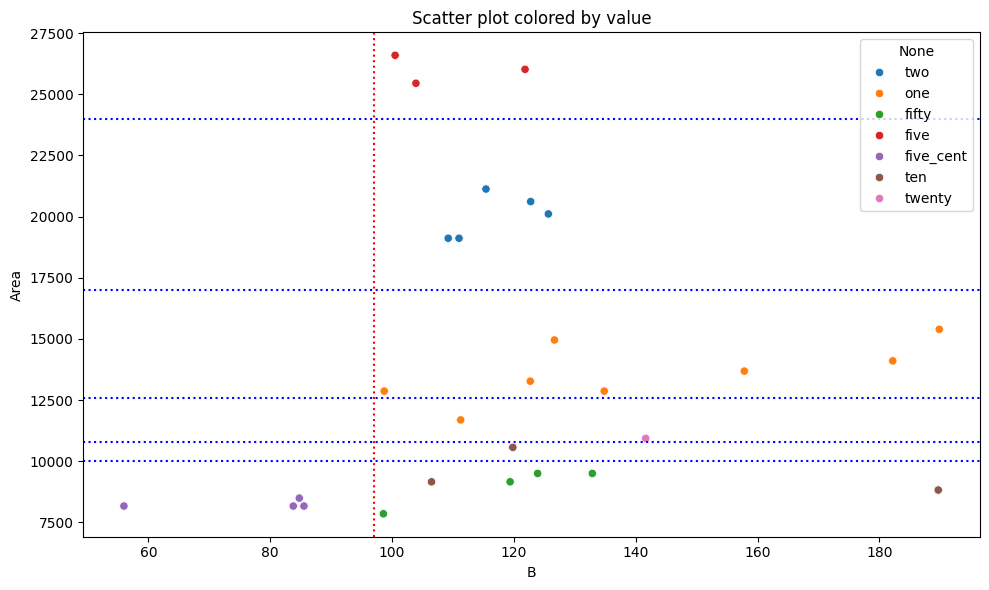

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='B', y='Area', hue=df.index)
plt.title('Scatter plot colored by value')
# Add dotted lines for Area
area_values = [24000, 17000, 12600, 10800, 10000]
for value in area_values:
    plt.axhline(y=value, color='b', linestyle=':', label=f'Area: {value}')
B_values = [97]
for value in B_values:
    plt.axvline(x=value, color='r', linestyle=':', label=f'Area: {value}')

plt.tight_layout()
plt.show()

We can see on the image above that by using the area and the mean value of the blue channel, we are able to classify the value of the francs with few errors. Using these thresholds, we thus crafted the following function:

In [ ]:
def classify_area_b(area, B):
    """
    Given an area and the mean of the blue channel, determine the value of a swiss franc coin.
    """
    # 0.05
    if B < 97 and area < 9000:
        return 6
    # 5
    if area > 24000:
        return 0
    # 2
    elif area > 17000:
        return 1
    # 1
    elif area > 12600:
        return 2
    # 0.2
    elif area > 10800:
        return 4
    # 0.1
    elif area > 10000:
        return 5
    # 0.5
    else:
        return 3

We tested this algorithm on our training set and obtained an accuracy of 93% and a F1-score of 66.5%

# 5. EURO Classifier
Our initial idea to classify euros was to not use any deep learning, but to simply rely on the size and the color of the coins to classify them into their exact values. To do so, similarly as in the CHF, we extracted the circles around the euros and computed the perimeters and the areas of a few coins of some training images. Additionally, for the same coins, we extracted the mean hue, saturation and value as well as the mean red, blue and green values for the center of each image. We then plotted them to see if we could find any threshold that could separate the classes.

In [ ]:
neutrals_list = ['L1010308.JPG', 'L1010323.JPG']
noisy_list = ['L1010331.JPG', 'L1010356.JPG']
hand_list = ['L1010395.JPG', 'L1010377.JPG']

cropped_images = []
for img_neutral in neutrals_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/neutral/' + img_neutral, image_type='neutral', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_noisy in noisy_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/noisy/' + img_noisy, image_type='noisy', display_cropped=False)
    cropped_images = cropped_images + cropped

for img_hand in hand_list:
    cropped, _ = detect_and_crop_coins(img_path=train_path + '/hand/' + img_hand, image_type='hand', display_cropped=False)
    cropped_images = cropped_images + cropped

circles = []
for img in cropped_images:
    circle = detect_circles_classification(img=img, display=False)
    circles.append(circle)

# Assume `circles` is already defined and contains the detected circles
properties = calculate_circle_properties(circles, cropped_images)

# Creating a DataFrame
labels = ['franc', 'ten', 'two', 'five', 'five', 'twenty', 'two_cent', 'two_cent', 'twenty', 'two', 'five', 'fifty', 'ten', 'twenty', 'one', 'one_cent', 'two_cent', 'franc', 'one', 'two_cent', 'two_cent', 'one_cent', 'fifty', 'fifty', 'five', 'two', 'twenty', 'two', 'ten', 'fifty', 'franc', 'fifty', 'one_cent', 'five', 'franc', 'two', 'five', 'two_cent', 'franc']
df = pd.DataFrame(properties, columns=['Perimeter', 'Area', 'H', 'S', 'V', 'R', 'G', 'B'], index=labels)
df = df.drop('franc')
df

,Perimeter,Area,H,S,V,R,G,B
ten,370.707933,10935.884027,19.7332,149.1888,178.7532,178.7532,142.9976,74.5292
two,471.238898,17671.458676,19.3332,136.2364,180.4756,180.4756,146.1088,84.2804
five,402.123860,12867.963509,10.2188,144.6596,198.9892,198.9892,124.6736,86.3784
five,395.840674,12468.981242,14.2328,160.7404,174.5992,174.5992,116.9332,64.6144
twenty,414.690230,13684.777599,19.5736,143.2088,184.3596,184.3596,148.5748,81.3192
two_cent,351.858377,9852.034562,11.5456,145.4464,164.3648,164.3648,106.7888,70.8992
two_cent,351.858377,9852.034562,12.7292,145.7292,202.5476,202.5476,136.0164,87.0636
twenty,414.690230,13684.777599,19.7284,154.1624,190.8756,190.8756,151.4756,75.6512
two,452.389342,16286.016316,19.8068,136.7092,179.0680,179.0680,146.8364,83.2352
five,395.840674,12468.981242,10.5148,165.8036,174.2300,174.2300,101.2724,61.0044


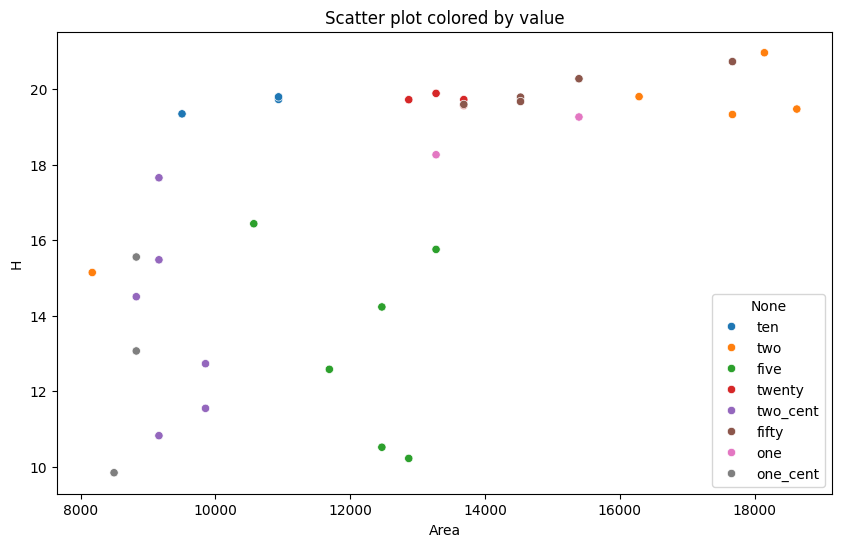

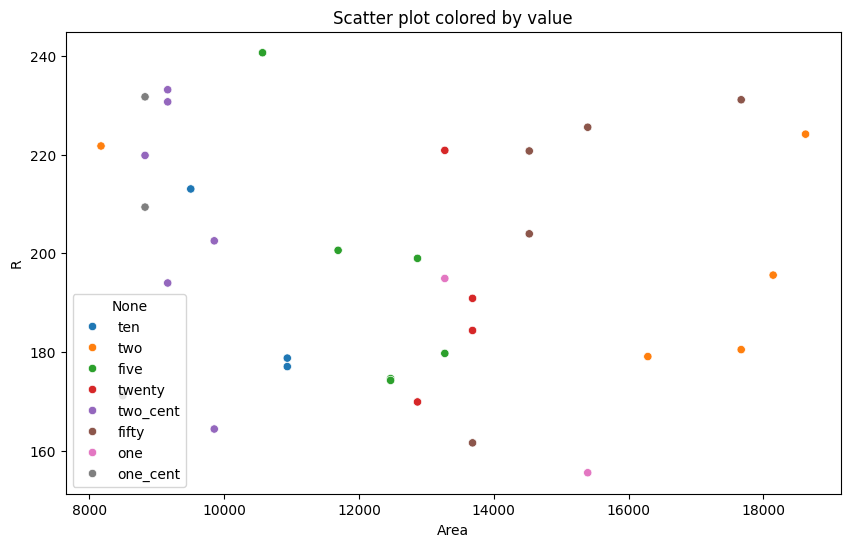

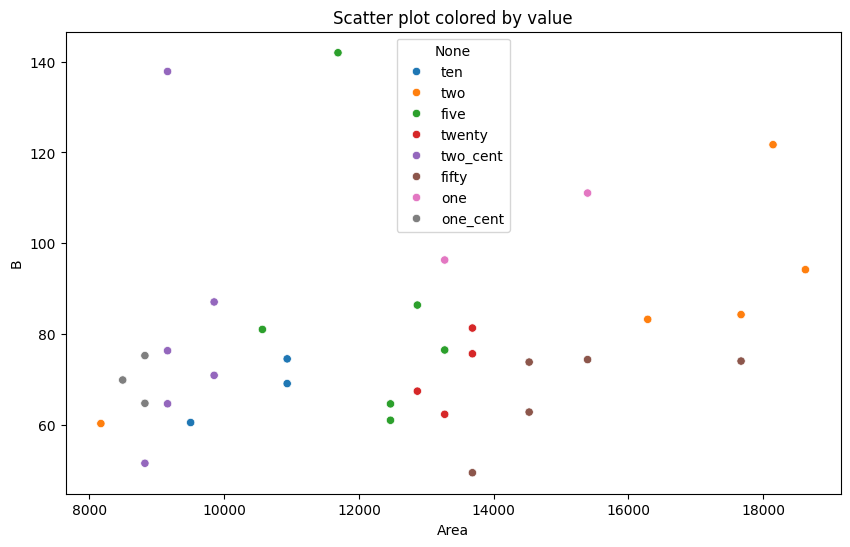

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='H', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='R', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='Area', y='B', hue=df.index)
plt.title('Scatter plot colored by value')
plt.show()

We just show a few plots above, but as you can see, it is hard to manually find a threshold to separate the coins. We thought that maybe when including all dimensions, coins of the same values would be clustered together. We thus tried to see if a KNN algorithm would be able to identify 8 clusters of points given the computed properties. Unfortunately, upon analysing the results, we concluded that the clustering was unsuccessful.
In the end, we therefore decided that the best way to classify these coins was also to use a supervised pre-trained deep learning model. At this stage, we labelled each euro coin present in our "cropped" directory with a label indicating its exact value. The cell below loads these labels, the labels indicated which coins are euros (see section 3) and the cropped images. We re-load all the images at this stage in order to make sure that the labels are in the same order as the images.

In [109]:
currency_labels = pd.read_csv('./data/CHF_EUR_OOD_labels.csv', sep=';', index_col=0)
labels_all = pd.read_csv('./data/euro_labels.csv', sep=',', index_col=0)
labels_euros = labels_all[labels_all['Label']!='Not euro']

images_euros = []
labels = []
ids_euros = []
for root, dirs, files in os.walk(cropped_path):
    for file in files:
        # construct path to the image file
        file_path = os.path.join(root, file)
        im = cv2.imread(file_path, cv2.IMREAD_COLOR)
        if im is not None:
            img_id = file[:-4]
            label = np.argmax(currency_labels.loc[int(img_id)].values)
            if label == 1:
                temp = preprocess(im).unsqueeze(0)
                temp = temp.reshape([3, 224, 224])
                images_euros.append(temp)
                labels.append(float(labels_euros.loc[int(img_id)].values[0]))
                ids_euros.append(img_id)

# one-hot encoding of the labels for easier training of the model
df_labels = pd.DataFrame(labels, columns=['value'], index=ids_euros)
one_hot_labels = pd.get_dummies(df_labels['value'])
one_hot_labels

,0.01,0.02,0.05,0.10,0.20,0.50,1.00,2.00
10,False,False,True,False,False,False,False,False
100,False,False,False,False,False,True,False,False
101,False,False,False,True,False,False,False,False
102,False,False,False,False,True,False,False,False
103,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...
93,False,False,False,True,False,False,False,False
94,False,False,False,False,True,False,False,False
95,False,False,False,False,False,False,True,False
98,False,False,False,False,False,False,False,True


In [110]:
# dataset creation
data = TensorDataset(torch.tensor(np.array(np.array(one_hot_labels)), dtype=torch.float32), torch.tensor(np.array(images_euros)))
train_size = int(0.75 * len(data))
val_size = len(data) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(data, [train_size, val_size])

We needed to use a small model and thus decided to try resnet18. We used the same pre-processing as for our CHF/EUR/OOD classifier since the models were pre-trained on the same dataset (imagenet1k). We explored a range of different learning rates and chose the one that gave the best results on our validation set.

In [ ]:
learning_rates= [0.1, 0.01, 0.03, 0.04, 0.05, 0.07, 0.001]

for lr in learning_rates:
    print(f"###### STARTING LEARNING RATE {lr} #######")
    torch.manual_seed(42)
    random.seed(42)
    np.random.seed(42)

    model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 8)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    # only optimise last layer (classifier)
    optimizer_conv = optim.SGD(model.fc.parameters(), lr=lr, momentum=0.9)
    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
        train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=21, batch_size=6)
    print(f"###### LEARNING RATE {lr} DONE #######")

We have found that the best learning rate for this model is 0.04. We thus train the model using the best learning rate and using early stopping to define the best epoch and avoid overfitting to the training set. Here again, we control the size of the model (106MB) and save the weights to not have to re-train the model.

In [111]:
model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)

model = model.to(device)
criterion = nn.CrossEntropyLoss()
# only optimise last layer (classifier)
optimizer_conv = optim.SGD(model.fc.parameters(), lr=0.04, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
model, train_losses, val_losses, train_acc, val_acc, train_f1, val_f1, preds = \
    train_model(model, criterion, optimizer_conv, exp_lr_scheduler, train_dataset, val_dataset, device, num_epochs=13, batch_size=6)

Epoch 0/12
----------
train Loss: 10.3175
train Accuracy: 0.2297
train F1-score: 0.1538
val Loss: 11.5649
val Accuracy: 0.3600
val F1-score: 0.2681
Epoch 1/12
----------
train Loss: 13.4891
train Accuracy: 0.3919
train F1-score: 0.2738
val Loss: 6.2474
val Accuracy: 0.4400
val F1-score: 0.3731
Epoch 2/12
----------
train Loss: 7.1837
train Accuracy: 0.5743
train F1-score: 0.4916
val Loss: 3.5121
val Accuracy: 0.6000
val F1-score: 0.5488
Epoch 3/12
----------
train Loss: 4.3789
train Accuracy: 0.7095
train F1-score: 0.6321
val Loss: 4.3063
val Accuracy: 0.5800
val F1-score: 0.4845
Epoch 4/12
----------
train Loss: 7.3431
train Accuracy: 0.6014
train F1-score: 0.5154
val Loss: 14.1731
val Accuracy: 0.4200
val F1-score: 0.3749
Epoch 5/12
----------
train Loss: 4.9846
train Accuracy: 0.7162
train F1-score: 0.6193
val Loss: 4.9136
val Accuracy: 0.6200
val F1-score: 0.5448
Epoch 6/12
----------
train Loss: 3.6130
train Accuracy: 0.7500
train F1-score: 0.6642
val Loss: 3.8265
val Accuracy: 0.

In [113]:
summary(model, preprocess(images_euros[0]).shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
#torch.save(model.state_dict(), './models/resnet_b32_lr4e2_step7_epoch10_split0.75')

# 6. Final submission
Here is the code to produce our final submission on Kaggle. We load the test images, predict their background and identify each coin using our segmentation functions. We then identify the currency of each coin using our fine-tuned alexnet. If it's a franc, we find its value using its size and its color. If it's a euro, we find its value using our fine-tuned resnet18.

For this code to run, the downsampling functions in section 2 must have been ran

In [ ]:
downsampled_test = "preprocessed_data/downsampled/test"
test_folder = "data/test"

model_path1 = "models/classifier_class3_b6_lr5e4_step7_epoch17_split0.75"
model_path2 = './models/resnet_b32_lr4e2_step7_epoch10_split0.75'

csv_file = "data/train_labels.csv"
csv_path = "submission.csv"

Choose folder to process

In [ ]:
folder = test_folder
downsampled_folder = downsampled_test

Background

In [ ]:
images, ids, backgrounds = load_images_and_backgrounds(folder, downsampled_folder)

Processing file L0000000.JPG
Processing file L0000001.JPG
Processing file L0000002.JPG
Processing file L0000003.JPG
Processing file L0000004.JPG
Processing file L0000005.JPG
Processing file L0000006.JPG
Processing file L0000007.JPG
Processing file L0000008.JPG
Processing file L0000009.JPG
Processing file L0000010.JPG
Processing file L0000011.JPG
Processing file L0000012.JPG
Processing file L0000013.JPG
Processing file L0000014.JPG
Processing file L0000015.JPG
Processing file L0000016.JPG
Processing file L0000017.JPG
Processing file L0000018.JPG
Processing file L0000019.JPG
Processing file L0000020.JPG
Processing file L0000021.JPG
Processing file L0000022.JPG
Processing file L0000023.JPG
Processing file L0000024.JPG
Processing file L0000025.JPG
Processing file L0000026.JPG
Processing file L0000027.JPG
Processing file L0000028.JPG
Processing file L0000029.JPG
Processing file L0000030.JPG
Processing file L0000031.JPG
Processing file L0000032.JPG
Processing file L0000033.JPG
Processing fil

Predictions

In [ ]:
predictions, subclasses = predict(images, ids, backgrounds, model_path1, model_path2)

L0000000
L0000001
L0000002
L0000003
L0000004
L0000005
L0000006
L0000007
L0000008
L0000009
L0000010
L0000011
L0000012
L0000013
L0000014
L0000015
L0000016
L0000017
L0000018
L0000019
L0000020
L0000021
L0000022
L0000023
L0000024
L0000025
L0000026
L0000027
L0000028
L0000029
L0000030
L0000031
L0000032
L0000033
L0000034
L0000035
L0000036
L0000037
L0000038
L0000039
L0000040
L0000041
L0000042
L0000043
L0000044
L0000045
L0000046
L0000047
L0000048
L0000049
L0000050
L0000051
L0000052
L0000053
L0000054
L0000055
L0000056
L0000057
L0000058
L0000059
L0000060
L0000061
L0000062
L0000063
L0000064
L0000065
L0000066
L0000067
L0000068
L0000069
L0000070
L0000071
L0000072
L0000073
L0000074
L0000075
L0000076
L0000077
L0000078
L0000079
L0000080
L0000081
L0000082
L0000083
L0000084
L0000085
L0000086
L0000087
L0000088
L0000089
L0000090
L0000091
L0000092
L0000093
L0000094
L0000095
L0000096
L0000097
L0000098
L0000099
L0000100
L0000101
L0000102
L0000103
L0000104
L0000105
L0000106
L0000107
L0000108
L0000109
L0000110
L

In [ ]:
subclasses

{'L0000000': array([0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000001': array([0., 1., 1., 1., 2., 0., 1., 0., 2., 1., 0., 0., 1., 0., 0., 0.]),
 'L0000002': array([2., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000003': array([0., 0., 0., 3., 0., 0., 1., 0., 0., 0., 0., 1., 2., 0., 0., 1.]),
 'L0000004': array([0., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]),
 'L0000005': array([1., 0., 1., 1., 3., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]),
 'L0000006': array([1., 1., 2., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2.]),
 'L0000007': array([0., 0., 3., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'L0000008': array([0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1.]),
 'L0000009': array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.]),
 'L0000010': array([0., 0., 0., 0., 0., 2., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1.]),
 'L0000011': array([1., 1., 0., 1., 1., 0., 0., 2., 0.

In [ ]:
generate_csv_file(subclasses, csv_path)